In [1]:
n_scenarios = 10000
pf_id = 2
name = 'Rhys'

In [2]:
from ema_workbench import (ScalarOutcome, Scenario, MultiprocessingEvaluator, SequentialEvaluator)
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench.analysis import parcoords
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.util import ema_logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ema_logging.log_to_stderr(ema_logging.INFO)

model, planning_steps = get_model_for_problem_formulation(pf_id)


In [3]:
directed_search_df = pd.read_csv('output/directed_search/Directed_Search_combined_1_results.csv')

Re-evaluate candidate solutions under uncertainty

We now have a large number of candidate solutions (policies), we can re-evaluate them over the various deeply uncertain factors to assess their robustness against uncertainties.

For this robustness evaluation, we need to explore the scenarios for each solution. It means that, if we would like to run for instance 1000 scenarios for each solution, we might have to execute a very large number of runs.




In [4]:
directed_narrow = directed_search_df['Expected Number of Deaths'] <= 0.0 
directed_narrow = directed_search_df[directed_narrow]
directed_narrow

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Case
54,0,0,0,0,0,0,0,0,0,0,...,4,7,0,0,0.0,2.560100e+08,0.000000e+00,0.0,0.0,0
76,0,0,0,0,0,0,0,1,0,0,...,1,4,0,0,0.0,1.662552e+08,3.070000e+07,0.0,0.0,0
88,0,1,0,0,0,0,0,0,1,0,...,0,4,0,0,0.0,1.239637e+08,1.153000e+08,0.0,0.0,0
134,0,1,0,0,0,0,1,0,1,0,...,0,3,0,0,0.0,1.169251e+08,2.672000e+08,0.0,0.0,0
256,0,0,0,0,0,0,0,0,0,0,...,3,2,0,0,0.0,1.151080e+08,0.000000e+00,0.0,0.0,1
268,0,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0.0,2.503721e+07,1.519000e+08,0.0,0.0,1
278,0,0,0,0,0,0,1,1,0,0,...,0,2,0,0,0.0,3.389903e+07,6.140000e+07,0.0,0.0,1
285,0,0,0,0,0,0,0,1,0,0,...,2,3,0,0,0.0,8.515974e+07,3.070000e+07,0.0,0.0,1
291,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0.0,0.000000e+00,2.731000e+08,0.0,0.0,1
410,1,1,1,1,1,1,0,1,1,1,...,1,8,5,7,0.0,6.576607e+08,1.588300e+09,0.0,0.0,2


In [5]:
policies = directed_narrow.drop([o.name for o in model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Case
54,0,0,0,0,0,0,0,0,0,0,...,5,0,0,4,1,4,7,0,0,0
76,0,0,0,0,0,0,0,1,0,0,...,3,0,0,5,0,1,4,0,0,0
88,0,1,0,0,0,0,0,0,1,0,...,3,0,0,5,1,0,4,0,0,0
134,0,1,0,0,0,0,1,0,1,0,...,2,0,0,3,2,0,3,0,0,0
256,0,0,0,0,0,0,0,0,0,0,...,7,0,0,1,0,3,2,0,0,1
268,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,1
278,0,0,0,0,0,0,1,1,0,0,...,0,0,0,1,0,0,2,0,0,1
285,0,0,0,0,0,0,0,1,0,0,...,0,0,0,3,0,2,3,0,0,1
291,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
410,1,1,1,1,1,1,0,1,1,1,...,8,1,3,9,7,1,8,5,7,2


In [6]:
from ema_workbench import Policy

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

**Perform 1000 scenarios for each of the policy options. Depending on how many solutions are left after implementing the constraint, consider using multiprocessing or ipyparallel to speed up calculations.**

If you want to use ipyparallel, don't forget to start ipcluster.

In [7]:

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)


[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 10000 scenarios * 12 policies * 1 model(s) = 120000 experiments
100%|███████████████████████████████| 120000/120000 [11:10:22<00:00,  2.98it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


We can now evaluate the **robustness** of each of the policy options based on these scenario results. We can calculate the robustness of a policy option in terms of its performance on an outcome indicator across the 1000 scenarios. In other words, we can identify how robust a policy is in terms of each outcome indicator, and investigate the robustness tradeoffs.  

There are multiple metrics to quantify robustness. On of them is the *signal to noise ratio*, which is simply the mean of a dataset divided by its standard deviation. For instance, for an outcome indicator to be maximized, we prefer a high average value across the scenarios, and a low standard deviation, implying a narrow range of uncertainty about the outcomes. Therefore, we want to maximize the signal-to-noise ratio. For an outcome indicator to be minimized, a lower mean and a lower standard deviation is preferred. Therefore the formulation should be different.

**Write a function to calculate the signal-to-noise ratio for both kinds of outcome indicators. Calculate the signal-to-noise ratios for each outcome and each policy option. Plot the tradeoffs on a parallel plot. Which solutions look like a good compromise policy?**

In [8]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std
    

There are various ways in which we could calculate the signal to noise ratio. Here, I choose to iterate over the policy first. Next, I iterate over the outcomes. For each outcome, I only retrieve the results associated with the current policy. Next, I can calculate the signal to noise ratio. 

I am reusing the direction that we already specified for each outcome of interest, to avoid duplicating code. Note that I enabled this already with how I defined the s_to_n function above.

To make visualization easy, I transform all my results into a dataframe at the end.

In [9]:
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores = scores.drop('RfR Investment Costs', axis=1)
# scores²

In [10]:
normalized_scores=(scores-scores.min())/(scores.max()-scores.min())
normalized_scores


,Expected Annual Damage,Dike Investment Costs,Evacuation Costs,Expected Number of Deaths
134,2.373991e-01,0.009610,0.175947,0.019833
256,8.388137e-01,0.000000,0.446836,0.057602
268,9.827326e-01,0.001029,1.000000,0.101031
278,9.341596e-01,0.002786,0.535258,0.134905
285,1.000000e+00,0.007000,0.244022,1.000000
291,9.463587e-01,0.000000,0.848188,0.091355
410,8.858725e-08,0.432440,0.000001,0.000000
437,1.611166e-07,0.472918,0.000000,0.000008
54,3.705792e-02,0.042084,0.000000,0.421295
705,0.000000e+00,1.000000,0.000000,0.000003


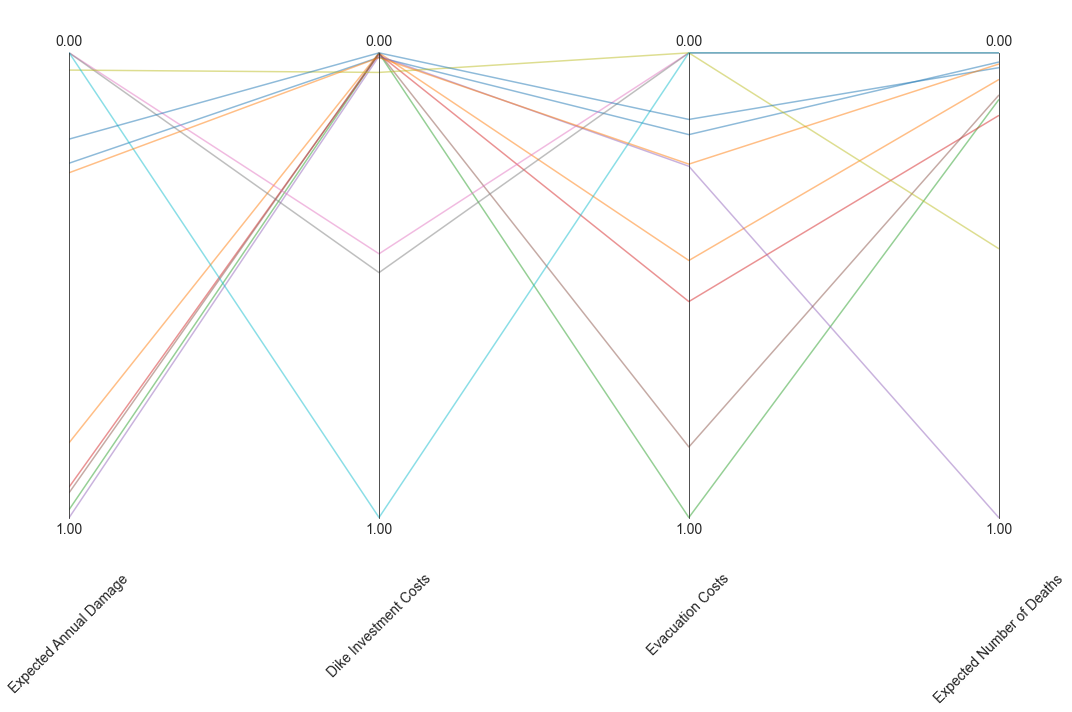

In [29]:


data = normalized_scores
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Dike Investment Costs', 'Evacuation Costs','Expected Number of Deaths']] = 0
plt.rcParams["figure.figsize"] = (15,10)
paraxes = parcoords.ParallelAxes(limits, rot=45)
paraxes.plot(data, alpha=0.5)
paraxes.invert_axis(['Expected Annual Damage', 'Dike Investment Costs', 'Evacuation Costs','Expected Number of Deaths'])

plt.savefig(f".\output\directed_search\Directed_Search_Scenario_Analysis_{name}_paracord_scores.svg", dpi=600, bbox_inches='tight')
plt.savefig(f".\output\directed_search\Directed_Search_Scenario_Analysis_{name}_paracord_scores.png", dpi=600, bbox_inches='tight')

plt.show()


The ideal solution would be a a high Signal to Noise score for reliability, inertia, and utility, and a low score for max_P. Such a solution clearly does not exist. The best solution for max_P and reliability score low on inertia and utility. No compromise solution can thus be found in this case. 


Another robustness metric is **maximum regret**, calculated again for each policy and for each outcome indicator. *Regret* is defined for each policy under each scenario, as the difference between the performance of the policy in a specific scenario and the berformance of a no-regret (i.e. best possible result in that scenario) or reference policy. The *maximum regret*  is then the maximum of such regret values across all scenarios. We of course favor policy options with low *maximum regret* values. 

**Write a function to calculate the maximum regret for both kinds of outcome indicators. Calculate the maximum regret values for each outcome and each policy option. Plot the tradeoffs on a parallel plot. Which solutions look like a good compromise policy?**

In [12]:
def calculate_regret(data, best):
    return np.abs(best-data)

Regret is the performance difference between the best possible outcome in a scenario across policies, the the observed outcome for a given policy. We have in this case both minimization and maximization. Best means the lowest in case of mimimization, and heighest in case of maximization. To avoid having to explicitly account for this in how we calculate the difference, we can simply take the absolute value of the difference. In this case, max_P will return negative regret values for `best-data`, so by taking the absolute value, we fix this

The next part of the code is probably the most tricky part. We need to find the best possible outcome for each scenario. We could do this by iterating over the scenario_id column in the experiment array. But we can also use pandas instead as done below. Wat we do is the following:
1. we create a dataframe with the outcome, the name of the policy and the scenario. This is a so called long-form representation of the data
2. We want to have the results for each policy side by side so we can take the max, or min accross the column. The pivot method on the DataFrame does this for us
3. We take the maximum or minimum accross the row.

In [13]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    

C:\Users\rhys_\AppData\Local\Temp\ipykernel_10464\3493117848.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\rhys_\AppData\Local\Temp\ipykernel_10464\3493117848.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\rhys_\AppData\Local\Temp\ipykernel_10464\3493117848.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\rhys_\AppData\Local\Temp\ipykernel_10464\34

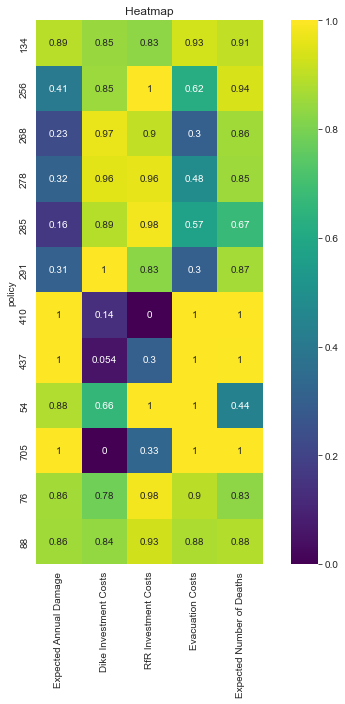

In [23]:
max_regret = pd.DataFrame(max_regret)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,10),
                       sharey=True, sharex=True)
ax.set_title("Heatmap")
sns.heatmap(max_regret/max_regret.max(), annot_kws={'size': 10}, cmap='viridis', square=True, annot=True, ax=ax)

plt.savefig(f".\output\directed_search\Directed_Search_Scenario_Analysis_{name}_heatmap.svg", dpi=600, bbox_inches='tight')
plt.savefig(f".\output\directed_search\Directed_Search_Scenario_Analysis_{name}_heatmap.png", dpi=600, bbox_inches='tight')

plt.show()

In [15]:
max_regret_normalized = (max_regret-max_regret.min())/(max_regret.max()-max_regret.min())
max_regret_normalized

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
134,0.870517,0.846233,0.831770,0.904088,0.831984
256,0.293242,0.848623,1.000000,0.463451,0.890207
268,0.079096,0.967074,0.904363,0.000000,0.750396
278,0.182207,0.955420,0.961342,0.261457,0.739698
285,0.000000,0.888008,0.980671,0.393048,0.418483
291,0.172870,1.000000,0.828055,0.002038,0.763414
410,1.000000,0.135119,0.000000,0.995718,1.000000
437,1.000000,0.054163,0.298369,1.000000,0.991677
54,0.859308,0.663325,1.000000,1.000000,0.000000


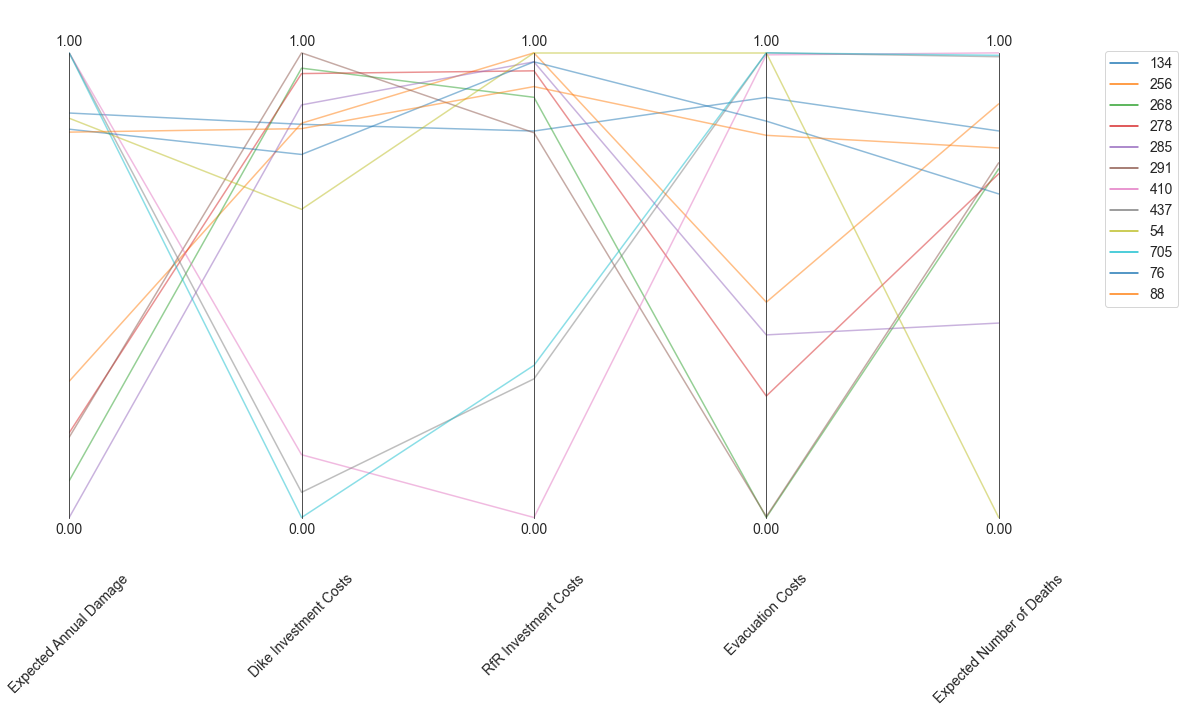

In [30]:

colors = sns.color_palette(n_colors=len(data))

data = max_regret_normalized

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Dike Investment Costs', 'Evacuation Costs','Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits, rot=45)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i], alpha=0.5)
paraxes.legend()

plt.savefig(f".\output\directed_search\Directed_Search_Scenario_Analysis_{name}_paracord_regret.svg", dpi=600, bbox_inches='tight')
plt.savefig(f".\output\directed_search\Directed_Search_Scenario_Analysis_{name}_paracord_regret.png", dpi=600, bbox_inches='tight')

plt.show()

We see striking differences between blue and orange (1 and 3) and green and red (5 and 8). The first two options have low regret on the first three objectives, but higher regret on utility. For the second two options it is reversed

Note that we have been looking at the maximum regret. I also saved the distribution of regret over the set of scenarios. So let's visualize this and see what we can learn from it


In [31]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

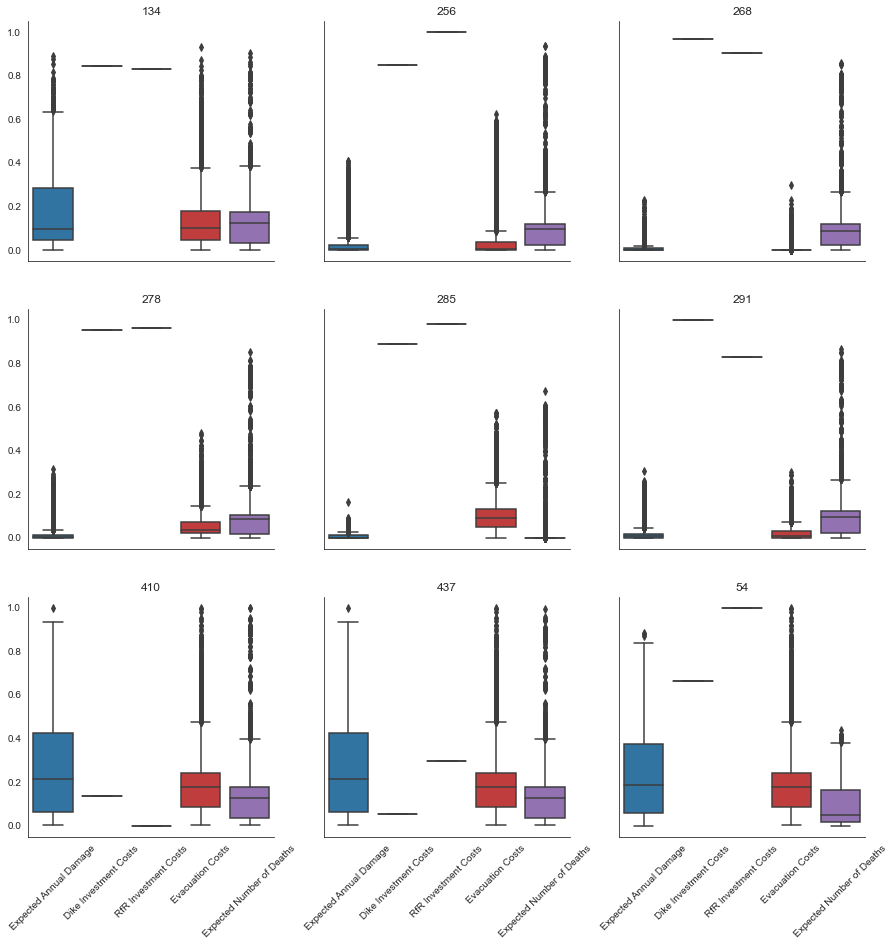

In [33]:
# this generates a 2 by 2 axes grid, with a shared X and Y axis
# accross all plots
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15,15),
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 
axes = [axes[0,0], axes[0,1], axes[0,2], axes[1,0], axes[1,1], axes[1,2],
        axes[2,0], axes[2,1], axes[2,2]]
# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))

    ax.tick_params(axis='x', rotation=45)

plt.savefig(f".\output\directed_search\Directed_Search_Scenario_Analysis_{name}_box_and_whiskers.svg", dpi=600, bbox_inches='tight')
plt.savefig(f".\output\directed_search\Directed_Search_Scenario_Analysis_{name}_box_and_whiskers.png", dpi=600, bbox_inches='tight')

plt.show()

This is in line with the maximum regret parallel coordinates plot, but we get some more details.

We now have an understanding of which solutions have decent robustness using 2 different robustness metrics. 


In [ ]:
# results.to_csv(f'./output/directed_search/Directed_Search_Scenario_Analysis_{name}.csv', index=False)

**Save files**

In [17]:
import pickle
with open(f'./output/directed_search/Directed_Search_Scenario_Analysis_{name}.kwakkel', 'wb') as filehandler:
    pickle.dump(results, filehandler)
    filehandler.close()

In [21]:
experiments, outcomes = results

try:
    experiments.to_csv(f'./output/directed_search/Directed_Search_Scenario_Analysis_{name}_exp.csv')
    pd.DataFrame.from_dict(outcomes).to_csv(f'./output/directed_search/Directed_Search_Scenario_Analysis_{name}_out.csv')
except:
    print("Unable to save as csv files")

In [34]:
from ema_workbench import save_results

save_results(results, f'./output/directed_search/Directed_Search_Scenario_Analysis_{name}.tar.gz')

[MainProcess/INFO] results saved successfully to C:\Users\rhys_\OneDrive - Maastricht University\Documents\GitHub\MBDM\final assignment\output\directed_search\Directed_Search_Scenario_Analysis_Rhys.tar.gz
